In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

width = 12
height = 7
plt.rcParams["figure.figsize"] = (width, height)


from sqlalchemy import create_engine
import pandas as pd
import numpy as np
import tflscripts
import json
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Imputer
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from statistics import mode

In [2]:
activities = [
    "Dishes",
    "Microwave",
    "Coffee",
    "Null",
    "Kettle",
    "Chopping food",
    "Conversation",
    "Eating popcorn",
    "Knocking",
    "Phone vibrating"
]

configuration = tflscripts.read_configuration()
activities_i = [configuration['activities'].index(a) for a in activities]

tflscripts.set_dataset_folder('/home/giotto/transfer-learning-playground/datasets/')

use_features = "^(?!mag|light)"

In [8]:
dataset = 'synergy-final-iter1-1s'
device = '128.237.254.195'

df, df_labels = tflscripts.read_and_filter_dataset(
        dataset,
        device,
        use_features='.*',
        use_activities=activities_i,
        scale=True,
        with_feature_selection=False)

for label in df_labels.label.unique():
    df_labels_modified = df_labels.copy()
    df_labels_modified.loc[df_labels.label != label, 'label'] = -1

    dfs = tflscripts.take_multiple_percentages_of_data(
            df, df_labels_modified,
            [0.7, 0.3])

    X_train, y_train = dfs[0]
    X_test, y_test = dfs[1]

    y_train = y_train['label']
    y_test = y_test['label']

    ppl = Pipeline([
        ('impute', Imputer()),
        ('clf', svm.SVC(kernel='linear', decision_function_shape='ovr', probability=True))
    ])

    ppl.fit(X_train, y_train)

    predicted = ppl.predict(X_test)
    proba = pd.DataFrame(ppl.predict_proba(X_test))
    proba.columns = [-1, label]
    [1]
    plt.show()

    accuracy = accuracy_score(y_test, predicted)
    print(configuration['activities'][label], accuracy)

Null 0.987027027027
Microwave 0.996756756757
Kettle 0.971891891892
Chopping food 0.961081081081
Coffee 0.907027027027
Dishes 1.0
Conversation 0.995675675676
Eating popcorn 0.967567567568
Phone vibrating 0.96972972973
Knocking 0.998918918919


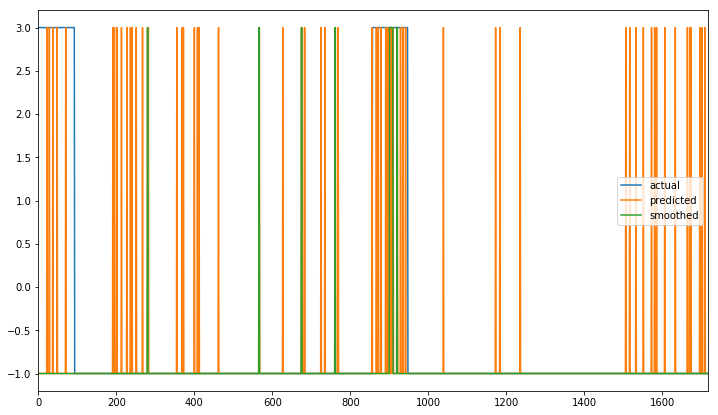

Null 0.896451425247


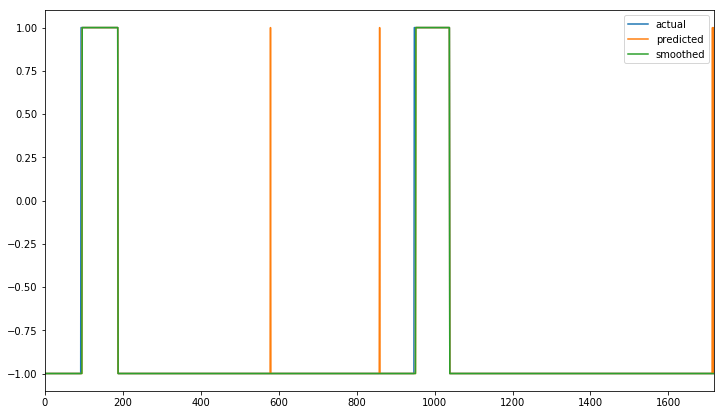

Microwave 0.995927865038


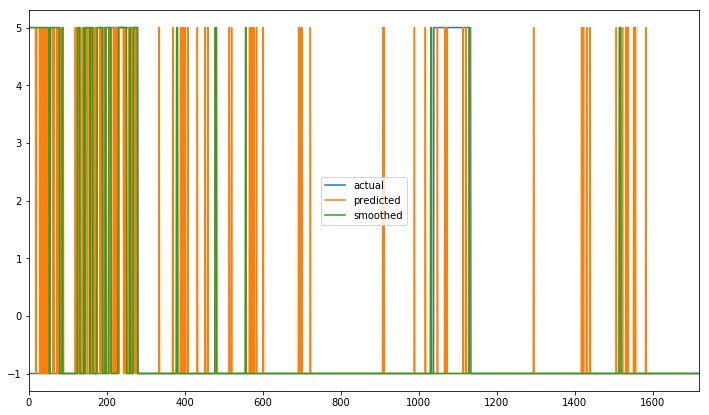

Kettle 0.841768470041


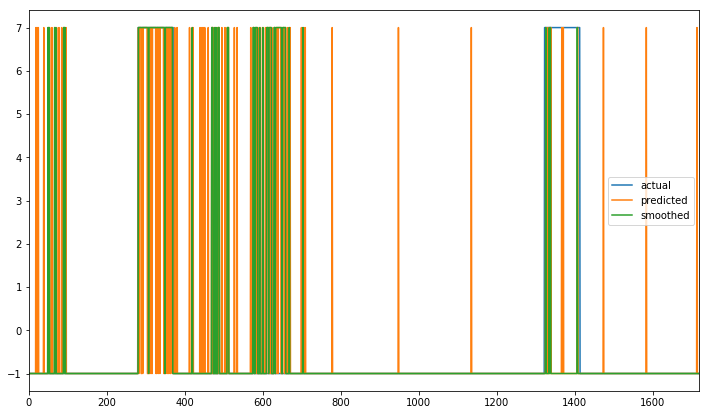

Chopping food 0.902268760908


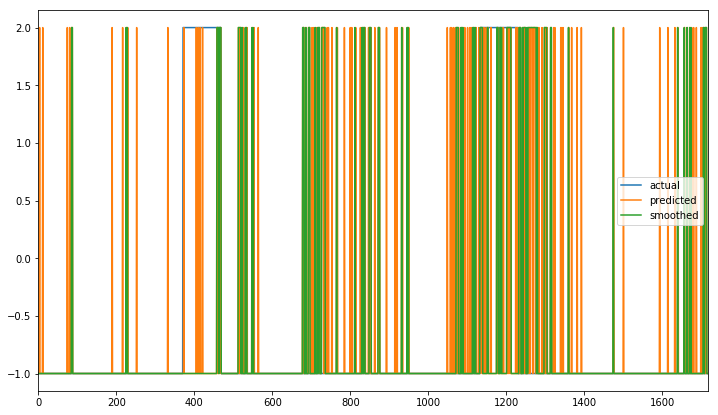

Coffee 0.823734729494


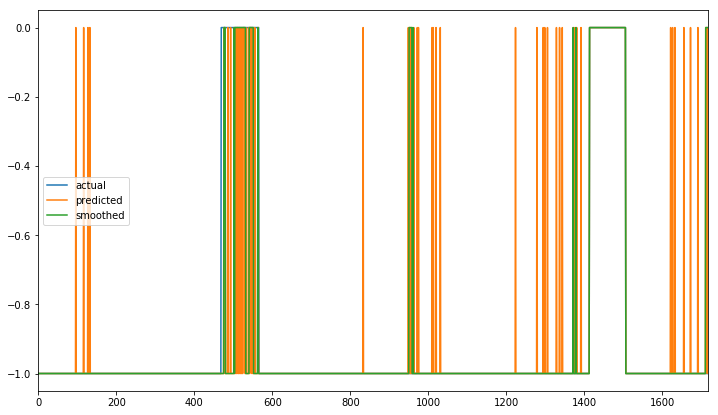

Dishes 0.959278650378


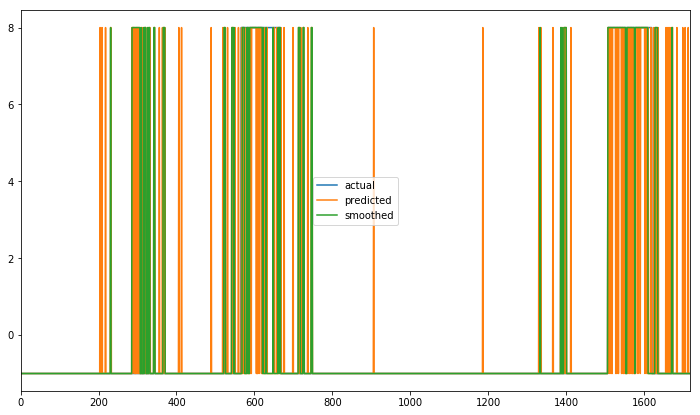

Conversation 0.914485165794


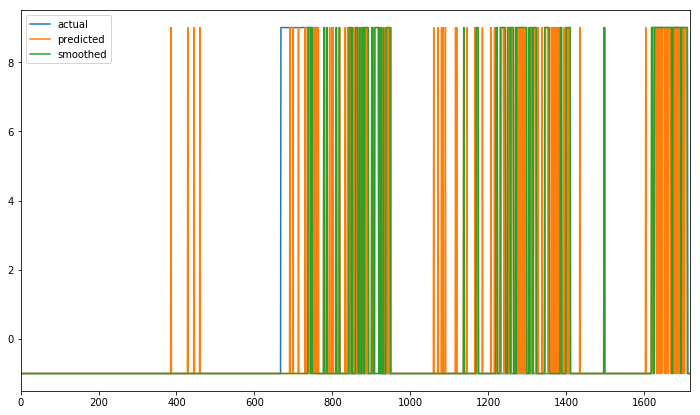

Eating popcorn 0.842931937173


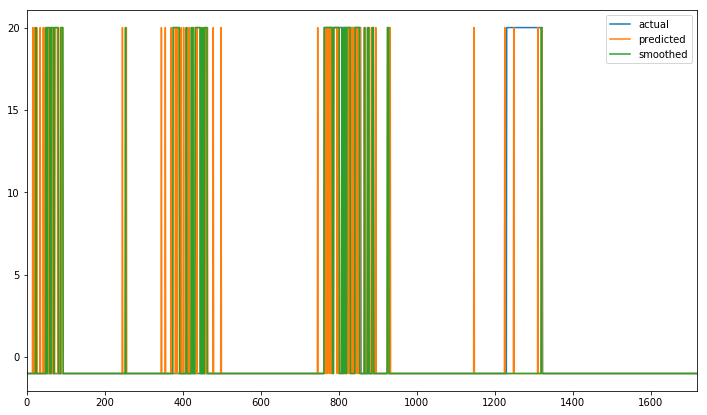

Phone vibrating 0.874927283304


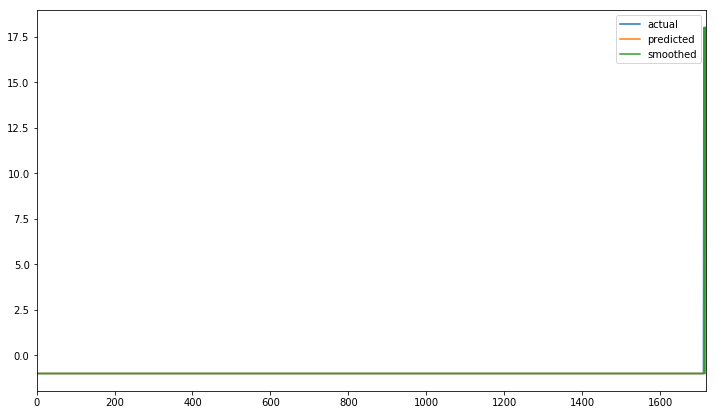

Knocking 0.998254799302


In [31]:
source_dataset = 'synergy-final-iter1'
source_device = 'Matrix b827eb41f96f'
target_dataset = 'synergy-final-iter2'
target_device = 'Matrix b827ebe6e0f8'

df_source, df_source_labels = tflscripts.read_and_filter_dataset(
        source_dataset + '-2s',
        source_device,
        use_features='.*',
        use_activities=activities_i,
        scale=True,
        with_feature_selection=False)

df_target, df_target_labels = tflscripts.read_and_filter_dataset(
        target_dataset + '-2s',
        target_device,
        use_features='.*',
        use_activities=activities_i,
        scale=True,
        with_feature_selection=False)

df_source = df_source.loc[df_source.index.isin(df_source_labels.index)]
df_target = df_target.loc[df_target.index.isin(df_target_labels.index)]

df_source_labels = df_source_labels.loc[df_source_labels.index.isin(df_source.index)]
df_target_labels = df_target_labels.loc[df_target_labels.index.isin(df_target.index)]

for label in df_source_labels.label.unique():
    df_source_labels_modified = df_source_labels.copy()
    df_source_labels_modified.loc[df_source_labels_modified.label != label, 'label'] = -1

    df_target_labels_modified = df_target_labels.copy()
    df_target_labels_modified.loc[df_target_labels_modified.label != label, 'label'] = -1

    y_train = df_source_labels_modified['label']
    y_test = df_target_labels_modified['label']

    ppl = Pipeline([
        ('impute', Imputer()),
        ('clf', svm.SVC(kernel='linear', decision_function_shape='ovr'))
    ])

    ppl.fit(df_source, y_train)

    predicted = ppl.predict(df_target)
    smoothed = tflscripts.smooth_predictions(predicted, label)
    proba = pd.DataFrame({'predicted': predicted, 'smoothed': smoothed, 'actual': y_test.values})
    proba.plot()
    plt.show()

    accuracy = accuracy_score(y_test, smoothed)
    print(configuration['activities'][label], accuracy)